Find the repo_id corresponding to the Bot account.

In [ ]:
from clickhouse_driver import Client
import pandas as pd

# Set up ClickHouse client connection
client = Client(host='',
                user='',
                password='',
                database='')

# Read bothawk_data.csv and extract the actor_id with label Bot.
bothawk_data_file = 'data/bothawk_data.csv'
bothawk_data = pd.read_csv(bothawk_data_file)
data_bot = bothawk_data[bothawk_data['label'] == 'Bot']

# Build a list of actor_ids for SQL query.
actor_ids = ','.join([str(i) for i in data_bot['actor_id'].unique()])  # 确保actor_id是唯一的

# Build query statement
query = f'''
SELECT actor_id, arrayDistinct(groupArray(repo_id)) as repo_ids
    FROM events
    WHERE actor_id IN ({actor_ids})
    GROUP BY actor_id
'''
# execute query
repo_data = client.execute(query)

repo_data_df = pd.DataFrame(repo_data, columns=['actor_id', 'repo_ids'])

repo_data_df.to_csv('data/bot_id_to_repo.csv', index=False)

print("Data has been successfully saved to 'data/bot_id_to_repo.csv'.")


## Find the repo_name

In [ ]:
from clickhouse_driver import Client
import pandas as pd

client = Client(host='',
                user='',
                password='',
                database='')

# Read bothawk_data.csv and extract actor_id with label Bot.
bothawk_data_file = 'data/bothawk_data.csv'
bothawk_data = pd.read_csv(bothawk_data_file)
data_bot = bothawk_data[bothawk_data['label'] == 'Bot']

actor_ids = ','.join([str(i) for i in data_bot['actor_id'].unique()])  # Ensure that the actor_id is unique.

# Build a query statement and use argMax to obtain the latest repo_name.
query = f'''
SELECT
    repo_id,
    argMax(repo_name, created_at) AS repo_name
FROM events
WHERE actor_id IN ({actor_ids})
GROUP BY repo_id
'''

repo_data = client.execute(query)

repo_data_df = pd.DataFrame(repo_data, columns=['repo_id', 'repo_name'])

repo_data_df.to_csv('data/data_repo_name.csv', index=False)

print("Data has been successfully saved to 'data/data_repo_name.csv'.")


In [4]:
import pandas as pd

# 读取 CSV 文件
file_path = 'data/data_repo_name.csv'
df = pd.read_csv(file_path)
df
# # 获取数据的行数
# row_count = len(df)
#
# print(f"Total number of rows: {row_count}")


,repo_id,repo_name
0,508560327,glomero/glomero
1,341114642,MikhailTorokov/github-slideshow
2,286908585,miguelangeltorresfp/strapi-starter-gatsby-blog
3,468492223,abirismyname/create-discussion
4,173578080,odoo-mergebot-testing-org/repo
...,...,...
14317902,811308383,sheep-black/MY-ChatGPT-Next-Web
14317903,738215861,barakthullashaik/rest
14317904,276289329,urielcookies/roberto-barber
14317905,365644617,joseph22236/github-slideshow


## Save data for the first 100 events of each robot account.

In [ ]:
from clickhouse_driver import Client
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import os

# ClickHouse connection details
host = ''
user = ''
password = ''
database = ''

# Read data to get actor_ids
data_bot = pd.read_csv("data/bot_data.csv")
actor_ids = data_bot['actor_id'].unique()
actor_ids = actor_ids[:3]  # Limiting to first 3 actor_ids for testing

# List of specified types
types = [
    'PullRequestEvent', 'PullRequestReviewCommentEvent', 'CommitCommentEvent',
    'IssueCommentEvent', 'IssuesEvent'
]

# Function to get column names from ClickHouse table
def get_column_names():
    client = Client(host=host, user=user, password=password, database=database)
    query = "DESCRIBE TABLE events"
    columns = client.execute(query)
    client.disconnect()
    column_names = [col[0] for col in columns]
    return column_names

# Get column names
column_names = get_column_names()

# Function to query and save top 100 entries for each type and actor_id
def query_and_save_top100(event_type, progress_bar):
    # Create a new ClickHouse client for each thread
    client = Client(host=host, user=user, password=password, database=database)

    # Load any existing progress
    output_file = f"top100_{event_type}.csv"
    if os.path.exists(output_file):
        all_top100 = pd.read_csv(output_file)
    else:
        all_top100 = pd.DataFrame(columns=column_names)

    # Determine which actor_ids have already been processed
    processed_actor_ids = set(all_top100['actor_id'].unique())

    rows_since_last_save = 0

    # Fetch top 100 rows for each actor_id
    for actor_id in actor_ids:
        if actor_id in processed_actor_ids:
            continue
        try:
            query = f"""
            SELECT *
            FROM events
            WHERE type = '{event_type}' AND actor_id = '{actor_id}'
            LIMIT 100
            """
            data = client.execute(query)
            # Create DataFrame with the same column names as the database table
            df = pd.DataFrame(data, columns=column_names)
            if not df.empty and not df.isna().all(axis=None):
                all_top100 = pd.concat([all_top100, df], ignore_index=True)
                rows_since_last_save += len(df)
                # Save progress after every 1000 rows
                if rows_since_last_save >= 1000:
                    all_top100.to_csv(output_file, index=False)
                    rows_since_last_save = 0
        except Exception as e:
            print(f"Error processing actor_id {actor_id} for event_type {event_type}: {e}")
            continue

    # Save any remaining rows that haven't been saved yet
    if rows_since_last_save > 0:
        all_top100.to_csv(output_file, index=False)

    # Update progress bar
    progress_bar.update(1)

    # Disconnect the client
    client.disconnect()

# Function to run in parallel
def process_event_type(event_type, progress_bar):
    query_and_save_top100(event_type, progress_bar)

# Use ThreadPoolExecutor to run queries in parallel with a progress bar
with ThreadPoolExecutor(max_workers=len(types)) as executor:
    with tqdm(total=len(types), desc="Processing Event Types") as progress_bar:
        futures = [executor.submit(process_event_type, event_type, progress_bar) for event_type in types]
        for future in futures:
            future.result()  # Wait for each future to complete


### Filter out dissimilar content in the data without using a threshold value, and the calculation process is in process_event_comments_similarity.py.
### Comparison of information retention rate under different similarity threshold.

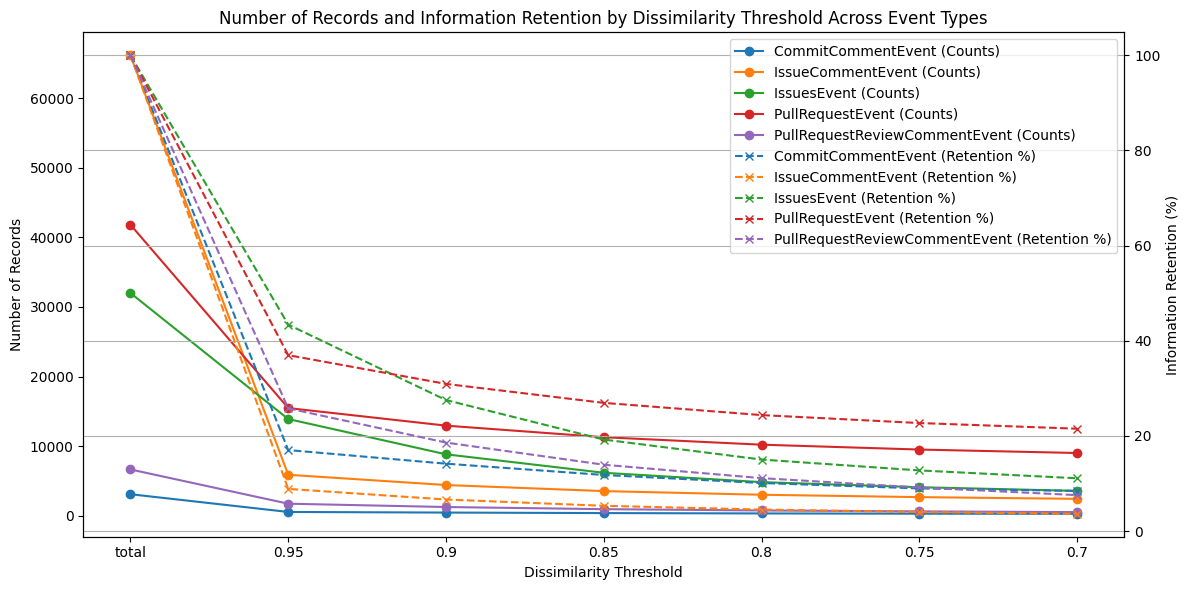

In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Directory and file information
data_dir = 'data/comment_data_dissimilar_analysis'
event_types = {
    'CommitCommentEvent': [
        'top100_CommitCommentEvent.csv',
        'top100_CommitCommentEvent_dissimilar_bodies_threshold_0.95.csv',
        'top100_CommitCommentEvent_dissimilar_bodies_threshold_0.9.csv',
        'top100_CommitCommentEvent_dissimilar_bodies_threshold_0.85.csv',
        'top100_CommitCommentEvent_dissimilar_bodies_threshold_0.8.csv',
        'top100_CommitCommentEvent_dissimilar_bodies_threshold_0.75.csv',
        'top100_CommitCommentEvent_dissimilar_bodies_threshold_0.7.csv'
    ],
    'IssueCommentEvent': [
        'top100_IssueCommentEvent.csv',
        'top100_IssueCommentEvent_dissimilar_bodies_threshold_0.95.csv',
        'top100_IssueCommentEvent_dissimilar_bodies_threshold_0.9.csv',
        'top100_IssueCommentEvent_dissimilar_bodies_threshold_0.85.csv',
        'top100_IssueCommentEvent_dissimilar_bodies_threshold_0.8.csv',
        'top100_IssueCommentEvent_dissimilar_bodies_threshold_0.75.csv',
        'top100_IssueCommentEvent_dissimilar_bodies_threshold_0.7.csv'
    ],
    'IssuesEvent': [
        'top100_IssuesEvent.csv',
        'top100_IssuesEvent_dissimilar_bodies_threshold_0.95.csv',
        'top100_IssuesEvent_dissimilar_bodies_threshold_0.9.csv',
        'top100_IssuesEvent_dissimilar_bodies_threshold_0.85.csv',
        'top100_IssuesEvent_dissimilar_bodies_threshold_0.8.csv',
        'top100_IssuesEvent_dissimilar_bodies_threshold_0.75.csv',
        'top100_IssuesEvent_dissimilar_bodies_threshold_0.7.csv'
    ],
    'PullRequestEvent': [
        'top100_PullRequestEvent.csv',
        'top100_PullRequestEvent_dissimilar_bodies_threshold_0.95.csv',
        'top100_PullRequestEvent_dissimilar_bodies_threshold_0.9.csv',
        'top100_PullRequestEvent_dissimilar_bodies_threshold_0.85.csv',
        'top100_PullRequestEvent_dissimilar_bodies_threshold_0.8.csv',
        'top100_PullRequestEvent_dissimilar_bodies_threshold_0.75.csv',
        'top100_PullRequestEvent_dissimilar_bodies_threshold_0.7.csv'
    ],
    'PullRequestReviewCommentEvent': [
        'top100_PullRequestReviewCommentEvent.csv',
        'top100_PullRequestReviewCommentEvent_dissimilar_bodies_threshold_0.95.csv',
        'top100_PullRequestReviewCommentEvent_dissimilar_bodies_threshold_0.9.csv',
        'top100_PullRequestReviewCommentEvent_dissimilar_bodies_threshold_0.85.csv',
        'top100_PullRequestReviewCommentEvent_dissimilar_bodies_threshold_0.8.csv',
        'top100_PullRequestReviewCommentEvent_dissimilar_bodies_threshold_0.75.csv',
        'top100_PullRequestReviewCommentEvent_dissimilar_bodies_threshold_0.7.csv'
    ]
}

# Generic labels for x-axis
threshold_labels = ['total', '0.95', '0.9', '0.85', '0.8', '0.75', '0.7']

# Function to count records in each file
def count_records(file_path):
    try:
        data = pd.read_csv(file_path)
        return len(data)
    except Exception as e:
        print(f"Error reading {file_path}: {str(e)}")
        return 0

# Plotting
plt.figure(figsize=(12, 6))
ax1 = plt.gca()  # get current axis
ax2 = ax1.twinx()  # create another axis that shares the same x-axis

for event_type, files in event_types.items():
    counts = [count_records(os.path.join(data_dir, file)) for file in files]

    if counts[0] == 0:
        print(f"Skipping {event_type} due to missing or empty initial data.")
        continue

    # Calculate information retention rate
    initial_count = counts[0]
    retention_rates = [count / initial_count * 100 if initial_count > 0 else 0 for count in counts]

    # Plot counts on the left y-axis
    ax1.plot(threshold_labels, counts, marker='o', label=f'{event_type} (Counts)')

    # Plot retention rates on the right y-axis
    ax2.plot(threshold_labels, retention_rates, marker='x', linestyle='--', label=f'{event_type} (Retention %)')

ax1.set_xlabel('Dissimilarity Threshold')
ax1.set_ylabel('Number of Records')
ax2.set_ylabel('Information Retention (%)')
plt.title('Number of Records and Information Retention by Dissimilarity Threshold Across Event Types')
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1 + h2, l1 + l2, loc='upper right')
plt.grid(True)
plt.tight_layout()

# Save the figure as a PDF
plt.savefig('chart/event_data_analysis.pdf')
plt.show()


### Calculate the number of active users for each warehouse.

In [ ]:
import pandas as pd
from clickhouse_driver import Client

csv_file = 'data/data_repo_name.csv'
repo_data = pd.read_csv(csv_file)
repo_ids = repo_data['repo_id'].unique()

host = ''
user = ''
password = ''
database = ''

client = Client(host=host, user=user, password=password, database=database)

batch_size = 100
results = []

for i in range(0, len(repo_ids), batch_size):
    batch_repo_ids = repo_ids[i:i + batch_size]

    query = f"""
    SELECT repo_id, COUNT(DISTINCT actor_id) AS actor_count
    FROM events
    WHERE repo_id IN ({','.join(map(str, batch_repo_ids))})
    GROUP BY repo_id
    """

    result = client.execute(query)

    results.extend(result)

    print(f"Processed batch {i//batch_size + 1}: {len(batch_repo_ids)} repos")

result_df = pd.DataFrame(results, columns=['repo_id', 'actor_count'])
result_df.to_csv('data/repo_actor_count_results.csv', index=False)

print("All batches processed and results saved to repo_actor_count_results.csv")


### Calculate repo information for different participating users.

In [10]:
import pandas as pd

# 读取结果文件
file_path = 'data/repo_actor_count_results.csv'
df = pd.read_csv(file_path)

# 计算总的 repo_id 数量
total_repos = len(df)

# 计算各个条件下的数量和比例
count_greater_than_5 = len(df[df['actor_count'] > 5])
count_greater_than_10 = len(df[df['actor_count'] > 10])
count_greater_than_15 = len(df[df['actor_count'] > 15])
count_greater_than_20 = len(df[df['actor_count'] > 100])

proportion_greater_than_5 = count_greater_than_5 / total_repos * 100
proportion_greater_than_10 = count_greater_than_10 / total_repos * 100
proportion_greater_than_15 = count_greater_than_15 / total_repos * 100
proportion_greater_than_20 = count_greater_than_20 / total_repos * 100

# 输出结果
print(f"Actor count > 5: {count_greater_than_5} repos, proportion: {proportion_greater_than_5:.2f}%")
print(f"Actor count > 10: {count_greater_than_10} repos, proportion: {proportion_greater_than_10:.2f}%")
print(f"Actor count > 15: {count_greater_than_15} repos, proportion: {proportion_greater_than_15:.2f}%")
print(f"Actor count > 100: {count_greater_than_20} repos, proportion: {proportion_greater_than_20:.2f}%")


Actor count > 5: 1321298 repos, proportion: 9.24%
Actor count > 10: 744337 repos, proportion: 5.20%
Actor count > 15: 558544 repos, proportion: 3.90%
Actor count > 100: 170753 repos, proportion: 1.19%


### 选取协作过的用户高于100的仓库

In [11]:
import pandas as pd

# 读取结果文件和数据文件
event_file_path = 'data/repo_actor_count_results.csv'
repo_file_path = 'data/data_repo_name.csv'

event_df = pd.read_csv(event_file_path)
repo_df = pd.read_csv(repo_file_path)

# 筛选出 actor_count > 100 的 actor_id
actor_ids_over_100 = event_df[event_df['actor_count'] > 100]['repo_id']

# 从 data_repo_name.csv 中筛选出对应的 actor_id
filtered_repo_df = repo_df[repo_df['repo_id'].isin(actor_ids_over_100)]

# 将结果保存为新的 CSV 文件
output_file_path = 'data/filtered_repo_by_actor_count.csv'
filtered_repo_df.to_csv(output_file_path, index=False)

print(f"Filtered data saved to {output_file_path}")


Filtered data saved to data/filtered_repo_by_actor_count.csv


In [23]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import MultiLabelBinarizer

# 读取 CSV 文件
df1 = pd.read_csv('data/bot_label_result_1/merged_bot_data.csv')
df2 = pd.read_csv('data/bot_label_result_2/merged_bot_data.csv')

# 保证两个 DataFrame 只保留需要的列，并去除空值
df1 = df1[['actor_id', 'types']].dropna()
df2 = df2[['actor_id', 'types']].dropna()

# 合并两个 DataFrame，根据 actor_id 对齐数据
merged_df = pd.merge(df1, df2, on='actor_id', suffixes=('_1', '_2'))

# 将字符串列表转换为 Python 列表对象
merged_df['types_1'] = merged_df['types_1'].apply(eval)
merged_df['types_2'] = merged_df['types_2'].apply(eval)

# 使用 MultiLabelBinarizer 将 types 列中的类型标签转为多标签的二进制格式
mlb = MultiLabelBinarizer()

# 对 types 列进行适配，返回类型矩阵
types_1_encoded = mlb.fit_transform(merged_df['types_1'])
types_2_encoded = mlb.transform(merged_df['types_2'])  # 用相同的标签适配 types_2

# 对比类型标签并计算 Cohen's Kappa Score
kappa = cohen_kappa_score(types_1_encoded.flatten(), types_2_encoded.flatten())

# 输出结果
print(f"Cohen's Kappa Score: {kappa}")

Cohen's Kappa Score: 0.6767257207608586


/Users/bifenglin/opt/anaconda3/envs/graph/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Bot', 'CommitCommentEvent', 'IssueCommentEvent'] will be ignored
  warnings.warn(
